In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import shutil
import string
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, Bidirectional, LSTM, Embedding, BatchNormalization,  Reshape, Conv2D, MaxPool2D, concatenate, Flatten, Activation
import torch
import numpy as np
from transformers import BertTokenizer, BertModel,RobertaTokenizer, RobertaModel
import ast

In [ ]:
# Verificar si la GPU está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# AST spliter D. Gries form

In [ ]:
class WhileLoopFinder(ast.NodeVisitor):
    def __init__(self, source_code):
        self.source_code = source_code.splitlines()
        self.functions_with_while = []
        self.current_function = None

    def visit_FunctionDef(self, node):
        original_current_function = self.current_function
        self.current_function = {
            "function_name": node.name,
            "has_while_loop": False,
            "pre_while_code_lines": [],
            "while_loops": []
        }

        function_start_line = node.lineno - 1
        function_end_line = (node.end_lineno if hasattr(node, 'end_lineno') else len(self.source_code))
        function_lines = self.source_code[function_start_line:function_end_line]

        found_while = False
        for stmt in node.body:
            if isinstance(stmt, ast.While):
                self.current_function["has_while_loop"] = True
                found_while = True
                try:
                    while_condition = ast.unparse(stmt.test).strip()
                    print("OK condition")
                except AttributeError:
                    print("Error al obtener la condición del while")
                try:
                    while_body_code = ast.unparse(ast.Module(body=stmt.body, type_ignores=[])).strip()
                    print("Ok body")
                except AttributeError:
                    print("Error al obtener el código del cuerpo del while")

                self.current_function["while_loops"].append({
                    "condition": while_condition,
                    "body_code": while_body_code
                })
            elif not found_while:
                start_line = stmt.lineno - 1
                end_line = (stmt.end_lineno if hasattr(stmt, 'end_lineno') else stmt.lineno)
                self.current_function["pre_while_code_lines"].extend(self.source_code[start_line:end_line])
            self.generic_visit(stmt)

        if self.current_function["has_while_loop"]:
            last_while_end_line = None
            if self.current_function["while_loops"]:
                last_while_node = next((node for node in reversed(node.body) if isinstance(node, ast.While)), None)
                if last_while_node and hasattr(last_while_node, 'end_lineno'):
                    last_while_end_line = last_while_node.end_lineno
            post_while_code_lines = []
            if last_while_end_line:
                function_indent = len(self.source_code[node.lineno - 1]) - len(self.source_code[node.lineno - 1].lstrip())
                for line in self.source_code[last_while_end_line:function_end_line]:
                    if line.startswith(self.source_code[node.lineno - 1][:function_indent] + "    "):
                        post_while_code_lines.append(line[function_indent + 4:])
                    else:
                        post_while_code_lines.append(line[function_indent:])
            self.current_function["post_while_code_lines"] = "\n".join(post_while_code_lines).strip()
            self.current_function["pre_while_code_lines"] = "\n".join(self.current_function["pre_while_code_lines"]).strip()
            self.functions_with_while.append(self.current_function)

        self.current_function = original_current_function



In [ ]:
def DGries_states(solution):
  try:
    # Crear el AST
    tree = ast.parse(solution)
    # Recorrer el AST con nuestro visitante
    finder = WhileLoopFinder(solution)
    finder.visit(tree)
    for func_info in finder.functions_with_while:
      initial_state=func_info["pre_while_code_lines"] if func_info["pre_while_code_lines"] else False
      end_state=""
      transformation_state=""
      for j, wl in enumerate(func_info["while_loops"]):
          end_state=wl["condition"]
          transformation_state=wl["body_code"]

      if not initial_state:
        initial_state=transformation_state
      return initial_state,transformation_state,end_state
  except Exception as error:
    return "Exception:"+str(error),"Exception:"+str(error),"Exception:"+str(error)




# Encoder Description and Code

In [ ]:
class EncodeTextSource:
  def __init__(self):
    self.is_loadtokenizers=False



  def tokenize_and_generate_embeddings_descriptions(self,description):
    if not self.is_loadtokenizers:
      raise ValueError("tokenizers dont load")
    # Tokenize input description and move tokens to GPU
    tokens = self.beart_tokenizer.encode_plus(description, return_tensors="pt", truncation=True)
    tokens = {key: value.to(device) for key, value in tokens.items()}
    # Generate embeddings
    with torch.no_grad():
        outputs = self.beart_model(**tokens)
    # Extract embeddings for all tokens
    desc_embeddings = outputs.last_hidden_state.cpu().numpy()
    return desc_embeddings

  def tokenize_and_generate_embeddings_codes(self,code):
    if not self.is_loadtokenizers:
      raise ValueError("tokenizers dont load")
    # Tokenize input code and move tokens to GPU
    tokens = self.beart_tokenizer.encode_plus(code, return_tensors="pt", truncation=True)
    tokens = {key: value.to(device) for key, value in tokens.items()}
    # Generate embeddings
    with torch.no_grad():
        outputs = self.codebeart_model(**tokens)
    # Extract embeddings for all tokens
    code_embeddings = outputs.last_hidden_state.cpu().numpy()

    return code_embeddings

  def load_beart_tokenizer(self):
    # Verificar si la GPU está disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Cargar el tokenizer y el modelo en la GPU si está disponible
    model_name = "bert-base-uncased"
    self.beart_model = BertModel.from_pretrained(model_name)
    self.beart_tokenizer = BertTokenizer.from_pretrained(model_name)
    self.beart_model.to(device)

  def load_codebert_tokenizer(self):
    # Verificar si la GPU está disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Cargar el tokenizer y el modelo en la GPU si está disponible
    self.codebeart_tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
    self.codebeart_model = RobertaModel.from_pretrained("microsoft/codebert-base")
    self.codebeart_model.to(device)

  def start_tokenizer(self):
    self.load_beart_tokenizer()
    self.load_codebert_tokenizer()
    self.is_loadtokenizers=True




# All characteristics

In [ ]:
def categoricallabelAll(w):

  if w=="['Initial state']":
    return 0
  if w=="['Final state']":
    return 1
  if w=="['State transformation']":
    return 2
  if w=="['Initial state', 'Final state']":
    return 3
  if w=="['Initial state', 'State transformation']":
    return 4
  if w=="['Final state', 'State transformation']":
    return 5
  if w=="['Initial state', 'Final state', 'State transformation']":
    return 6
  return 7

category=np.array([
    'Initial state',
    'Final state',
    'State transformation',
    'Initial state, Final state',
    'Initial state, State transformation',
    'Final state, State transformation',
    'Initial state, Final state, State transformation'

])

# Load Dataset

In [ ]:
archivo_3 = '/content/drive/MyDrive/Ginna Tesis/DataProgramsandDescriptions-CatRetroalimentacion5000.xlsx'
train_full = pd.read_excel(archivo_3)

In [ ]:
train_full.head()

,No.,Problema,Solución,Estado incial,Estado final,Transformación de estado,Etiqueta 1,Etiqueta 2,Realimentación
0,1,Write a Python function that returns the facto...,def factorial(n):\n result = 1\n i = 1\n...,"result = 1, i = 1",i <= n,"result *= i, i += 1",Correct,['Correct'],NaN
1,2,Write a Python function that returns the sum o...,def sum_1_to_100():\n total = 0\n i = 1\...,"total = 0, i = 1, n = 100",i <= n,"total += i, i += 1",Correct,['Correct'],NaN
2,3,Write a Python function that prints the number...,def print_and_store():\n numbers = []\n ...,"numbers = [], i = 0, n = 10",i <= n,"print(i), numbers.append(i), i += 1",Correct,['Correct'],NaN
3,4,Write a Python function to print the numbers f...,def print_and_store_reverse():\n numbers = ...,"numbers = [], i = 10, n = 1",i >= n,"print(i), numbers.append(i), i -= 1",Correct,['Correct'],NaN
4,5,Write a Python function to check if a number i...,def is_prime(num):\n if num <= 1:\n ...,"i = 2, i = = 0:",i <= num//2,"if num % i == 0:, return False, i += 1",Correct,['Correct'],NaN


In [ ]:
train_full.drop(["No.","Realimentación","Estado incial","Estado final","Transformación de estado"],axis=1,inplace=True)
train_full

,Problema,Solución,Etiqueta 1,Etiqueta 2
0,Write a Python function that returns the facto...,def factorial(n):\n result = 1\n i = 1\n...,Correct,['Correct']
1,Write a Python function that returns the sum o...,def sum_1_to_100():\n total = 0\n i = 1\...,Correct,['Correct']
2,Write a Python function that prints the number...,def print_and_store():\n numbers = []\n ...,Correct,['Correct']
3,Write a Python function to print the numbers f...,def print_and_store_reverse():\n numbers = ...,Correct,['Correct']
4,Write a Python function to check if a number i...,def is_prime(num):\n if num <= 1:\n ...,Correct,['Correct']
...,...,...,...,...
4995,Write a Python function that returns the sum o...,def sum_of_first_five_numbers():\n number =...,Incorrect,"['Initial state', 'Final state']"
4996,Write a Python function that returns the facto...,def factorial(n):\n result = 0\n i = 0\n...,Incorrect,"['Initial state', 'Final state']"
4997,Write a Python function that prints the number...,def print_and_store_numbers():\n numbers = ...,Incorrect,"['Initial state', 'Final state']"
4998,Write a Python function to print the numbers f...,def print_and_store_numbers():\n numbers = ...,Incorrect,"['Initial state', 'Final state']"


In [ ]:
train_full[["Estado incial","Transformación de estado","Estado final"]]=train_full['Solución'].apply(DGries_states).apply(pd.Series)

Streaming output truncated to the last 5000 lines.
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK condition
Ok body
OK c

In [ ]:
train_full = train_full[train_full['Etiqueta 1']!='Correct'].copy()

In [ ]:
y=train_full['Etiqueta 2'].apply(categoricallabelAll)
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
train_full.dropna(inplace=True)

In [ ]:
np.unique(train_full['Etiqueta 2'])

array(["['Final state', 'State transformation']", "['Final state']",
       "['Initial state', 'Final state', 'State transformation']",
       "['Initial state', 'Final state']",
       "['Initial state', 'State transformation']", "['Initial state']",
       "['State transformation']"], dtype=object)

In [ ]:
encoder=Encoder()
encoder.start_tokenizer()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
%%time
problem=train_full['Problema'].apply(encoder.tokenize_and_generate_embeddings_descriptions).to_numpy()
startstate = train_full['Estado incial'].apply(encoder.tokenize_and_generate_embeddings_codes).to_numpy()
finalstate = train_full['Estado final'].apply(encoder.tokenize_and_generate_embeddings_codes).to_numpy()
transstate = train_full['Transformación de estado'].apply(encoder.tokenize_and_generate_embeddings_codes).to_numpy()

CPU times: user 2min 2s, sys: 554 ms, total: 2min 3s
Wall time: 2min 4s


In [ ]:
problem.shape,startstate.shape,finalstate.shape,transstate.shape

((3459,), (3459,), (3459,), (3459,))

In [ ]:
print(startstate.shape)
print(startstate[1262].shape)


(3459,)
(1, 9, 768)


In [ ]:
Xp=np.array([sentence[0].mean(axis=0) for sentence in problem])
Xs=np.array([sentence[0].mean(axis=0) for sentence in startstate])
Xf=np.array([sentence[0].mean(axis=0) for sentence in finalstate])
Xt=np.array([sentence[0].mean(axis=0) for sentence in transstate])
Xp.shape,Xs.shape,Xf.shape,Xt.shape

((3459, 768), (3459, 768), (3459, 768), (3459, 768))

In [ ]:
y=train_full['Etiqueta 2'].apply(categoricallabelAll)
y=y.to_numpy()
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
def mytraintestsplit(X,y,test_size=0.2 ,random_state=2023):
  n=y.shape[0]
  index=np.array(range(0,n))
  np.random.seed(2023)
  np.random.shuffle(index)
  ntest=int(n*test_size)
  ntrain=n-ntest
  Xshufle=[]
  for x in X:
    Xshufle.append(x[index])
  y=y[index]

  Xtrain=[]
  for x in Xshufle:
    Xtrain.append(x[0:ntrain])

  Xtest=[]
  for x in Xshufle:
    Xtest.append(x[ntrain:n])

  return np.array(Xtrain),np.array(Xtest),y[0:ntrain],y[ntrain:n]



In [ ]:
Xtrain,Xtest,ytrain,ytest=mytraintestsplit([Xp,Xs,Xt,Xf],y)

In [ ]:
Xtrain.shape, Xtest.shape, ytrain.shape,ytrain.shape

((4, 2768, 768), (4, 691, 768), (2768,), (2768,))

In [ ]:
4913*0.8

3930.4

# Keras model

In [ ]:
problem_input=Input((768,))

mlp_p=Dense(10000)(problem_input)
mlp_p=BatchNormalization()(mlp_p)
mlp_p=Activation('relu')(mlp_p)
mlp_p=Dropout(0.5)(mlp_p)

mlp_p=Dense(1000)(mlp_p)
mlp_p=BatchNormalization()(mlp_p)
mlp_p=Activation('relu')(mlp_p)
mlp_p=Dropout(0.2)(mlp_p)

mlp_p=Dense(10000)(mlp_p)
mlp_p=BatchNormalization()(mlp_p)
mlp_p=Activation('relu')(mlp_p)
mlp_p=Dropout(0.2)(mlp_p)

## Start vector

start_input=Input((768,))

mlp_s=Dense(10000)(start_input)
mlp_s=BatchNormalization()(mlp_s)
mlp_s=Activation('relu')(mlp_s)
mlp_s=Dropout(0.5)(mlp_s)

mlp_s=Dense(1000)(mlp_s)
mlp_s=BatchNormalization()(mlp_s)
mlp_s=Activation('relu')(mlp_s)
mlp_s=Dropout(0.2)(mlp_s)

mlp_s=Dense(10000)(mlp_s)
mlp_s=BatchNormalization()(mlp_s)
mlp_s=Activation('relu')(mlp_s)
mlp_s=Dropout(0.2)(mlp_s)


##Transformation vector

trass_input=Input((768,))

mlp_t=Dense(10000)(trass_input)
mlp_t=BatchNormalization()(mlp_t)
mlp_t=Activation('relu')(mlp_t)
mlp_t=Dropout(0.5)(mlp_t)

mlp_t=Dense(1000)(mlp_t)
mlp_t=BatchNormalization()(mlp_t)
mlp_t=Activation('relu')(mlp_t)
mlp_t=Dropout(0.2)(mlp_t)

mlp_t=Dense(10000)(mlp_t)
mlp_t=BatchNormalization()(mlp_t)
mlp_t=Activation('relu')(mlp_t)
mlp_t=Dropout(0.2)(mlp_t)


## Final vector

final_input=Input((768,))

mlp_f=Dense(10000)(final_input)
mlp_f=BatchNormalization()(mlp_f)
mlp_f=Activation('relu')(mlp_f)
mlp_f=Dropout(0.5)(mlp_f)

mlp_f=Dense(1000)(mlp_f)
mlp_f=BatchNormalization()(mlp_f)
mlp_f=Activation('relu')(mlp_f)
mlp_f=Dropout(0.2)(mlp_f)

mlp_f=Dense(10000)(mlp_f)
mlp_f=BatchNormalization()(mlp_f)
mlp_f=Activation('relu')(mlp_f)
mlp_f=Dropout(0.2)(mlp_f)

## Concatenate All models
combined = concatenate([mlp_p, mlp_s, mlp_t,mlp_f])

## output layer

output=Dense(8)(combined)
output=BatchNormalization()(output)
output=Activation('softmax')(output)

## Model

model = Model(inputs=[problem_input, start_input, trass_input,final_input], outputs=output)


model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10000)     │  7,690,000 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10000)     │  7,690,000 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10000)     │  7,690,000 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 10000)     │  7,690,000 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 10000)     │     40,000 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10000)     │     40,000 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10000)     │     40,000 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10000)     │     40,000 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 10000)     │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 10000)     │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 10000)     │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 10000)     │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10000)     │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 10000)     │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 10000)     │          0 │ activation_6[0][

 Total params: 111,460,040 (425.19 MB)

 Trainable params: 111,292,024 (424.55 MB)

 Non-trainable params: 168,016 (656.31 KB)

In [ ]:
adam = Adam(learning_rate=0.00001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=25)
mc = ModelCheckpoint('/content/drive/MyDrive/Ginna Tesis/best_finall.keras', monitor='val_accuracy', mode='max', save_best_only=True)
history=model.fit([Xtrain[0], Xtrain[1], Xtrain[2],Xtrain[3]],ytrain,batch_size=100,epochs=5000,
          validation_split=0.2,callbacks=[es, mc])

Epoch 1/5000
23/23 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.1713 - loss: 2.3518 - val_accuracy: 0.2708 - val_loss: 2.0601
Epoch 2/5000
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 116ms/step - accuracy: 0.3013 - loss: 1.8935 - val_accuracy: 0.2708 - val_loss: 2.0082
Epoch 3/5000
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.3983 - loss: 1.7008 - val_accuracy: 0.2708 - val_loss: 1.9799
Epoch 4/5000
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.4519 - loss: 1.6131 - val_accuracy: 0.2708 - val_loss: 1.9653
Epoch 5/5000
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.4934 - loss: 1.5620 - val_accuracy: 0.2708 - val_loss: 1.9579
Epoch 6/5000
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.5641 - loss: 1.4604 - val_accuracy: 0.2708 - val_loss: 1.9470
Epoch 7/5000
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5733 - loss: 1.4281 - val_accuracy: 0.2708 - val_loss: 1.9377
Epoch 8/5000
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 639ms/step - accuracy: 0.6042 - loss: 1.3966 - 

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [ ]:
N=len(train_loss)

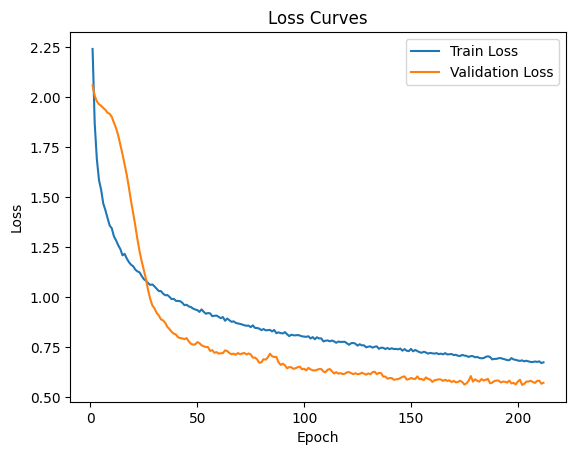

In [ ]:
import matplotlib.pyplot as plt


plt.plot(range(1, N+1), train_loss, label='Train Loss')
plt.plot(range(1, N+1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()


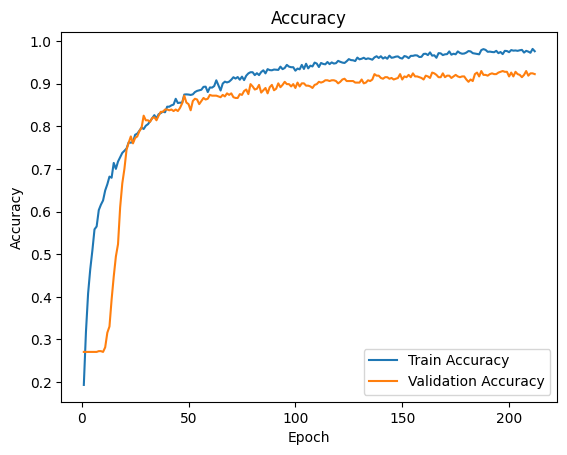

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, N+1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, N+1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
bestmodel = load_model('/content/drive/MyDrive/Ginna Tesis/best_finall.keras')

In [ ]:
yp=bestmodel.predict([Xtest[0],Xtest[1],Xtest[2],Xtest[3]])

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step


In [ ]:
print(classification_report(ytest,yp.argmax(axis=1),target_names=category))

                                                  precision    recall  f1-score   support

                                   Initial state       0.94      0.98      0.96       200
                                     Final state       0.97      0.99      0.98       195
                            State transformation       0.96      0.87      0.91       191
                      Initial state, Final state       0.86      1.00      0.93        25
             Initial state, State transformation       0.76      0.70      0.73        37
               Final state, State transformation       0.80      0.77      0.78        26
Initial state, Final state, State transformation       0.80      0.94      0.86        17

                                        accuracy                           0.93       691
                                       macro avg       0.87      0.89      0.88       691
                                    weighted avg       0.93      0.93      0.93       691

